# Observational impacts from compound modes

This file grabs the observed rainfall and temperature anomalies for each yeah and season and matches them with the events identifed in the obsIndeces file

In [1]:
import xarray

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

In [2]:
import utils.compound as compound
import utils.timePeriod as tp
import utils.sstIndex as sst
from helpers.fileHandler import to_365day_monthly 
import utils._indexDefinitions as _index

%run helpers/impactPlots.ipynb
%run utils/emergence.ipynb

# Load the Data

In [3]:
eventsXr=xarray.open_dataset('results/obsEvents.nc')

In [4]:
#anoms have already been calculated - see prelim/adcdPrTAnoms.ipynb file
impactXr=xarray.open_dataset('results/observPrTmaxAnoms.nc').sel(year=slice(1940,2019))

In [5]:
eventsLs = {
    'summer':['nino34','eIndex', 'nino3', 'cIndex','nino4', 'dmi','eastIO','samSummer'],
    'winter':['nino34','eIndex', 'nino3', 'cIndex', 'nino4','dmi','eastIO','samWinter']
}

I am calculating rainfall trends as a percent of the annual rain fall, by austral season

In [6]:
#change rainfall into % 
prXr=xarray.Dataset()
prXr['Winter Rain']=(impactXr.prAnomWinter/(impactXr['prWinter']+impactXr['prSummer'])*100)
prXr['Summer Rain']=(impactXr.prAnomSummer/(impactXr['prWinter']+impactXr['prSummer'])*100)

tsXr=(impactXr[['tsAnomWinter','tsAnomSummer']])
tsXr=tsXr.rename({'tsAnomWinter':'Winter Temp','tsAnomSummer':'Summer Temp'})

In [7]:
detrendTsXr=tsXr-tsXr.rolling(year=11,min_periods=5,center=True).mean('year')

In [8]:
detrendTsXr

<xarray.Dataset>
Dimensions:      (lat: 691, lon: 886, year: 80)
Coordinates:
  * lat          (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon          (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.2 156.2
  * year         (year) int64 1940 1941 1942 1943 1944 ... 2016 2017 2018 2019
Data variables:
    Winter Temp  (year, lat, lon) float32 -0.1562 -0.1565 ... 0.001872 0.001872
    Summer Temp  (year, lat, lon) float32 -0.09551 -0.09611 ... -8.128e-05

# Trends

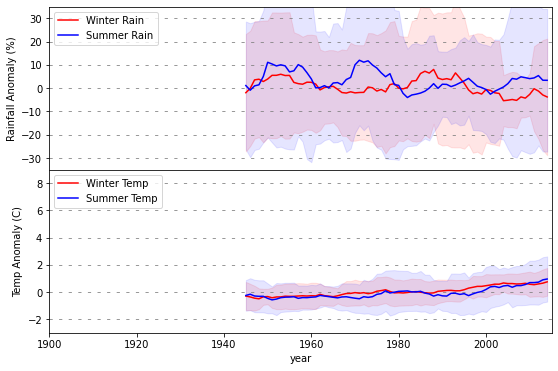

In [9]:
Z=1.96
mainColor=['red','blue','green','orange','purple']
plt.figure(figsize=(9,6))

plt.subplot(2,1,1)
dataVars=['Winter Rain','Summer Rain']
for i in range(0,len(dataVars)):
    iVar=dataVars[i]
    mean=domain(prXr)[iVar].mean(['lon','lat']).rolling(year=11,center=True).mean()
    std=domain(prXr)[iVar].mean(['lon','lat']).rolling(year=11,center=True).std()
    mean.plot(color=mainColor[i])
    plt.fill_between(
        mean.year.values,
        mean+Z*std,
        mean-Z*std,
        color=mainColor[i],
        alpha=0.1
    )
plt.legend(dataVars,loc='upper left')
plt.ylabel('Rainfall Anomaly (%)')
plt.xlim([1900,2015])
plt.ylim([-35,35])
plt.xticks([])
plt.grid(axis='y', color='grey', dashes=[4,8])


plt.subplot(2,1,2)
dataVars=['Winter Temp','Summer Temp']
for i in range(0,len(dataVars)):
    iVar=dataVars[i]
    mean=domain(tsXr)[iVar].mean(['lon','lat']).rolling(year=11,center=True).mean()
    std=domain(tsXr)[iVar].mean(['lon','lat']).rolling(year=11,center=True).std()
    mean.plot(color=mainColor[i])
    plt.fill_between(
        mean.year.values,
        mean+Z*std,
        mean-Z*std,
        color=mainColor[i],
        alpha=0.1
    )
plt.legend(dataVars,loc='upper left')
plt.xlim([1900,2015])
plt.ylim([-3,9])
plt.ylabel('Temp Anomaly (C)')
plt.grid(axis='y', color='grey', dashes=[4,8])


plt.subplots_adjust(hspace=0)




# Anoms for indiv indices

Fire:pos
winter


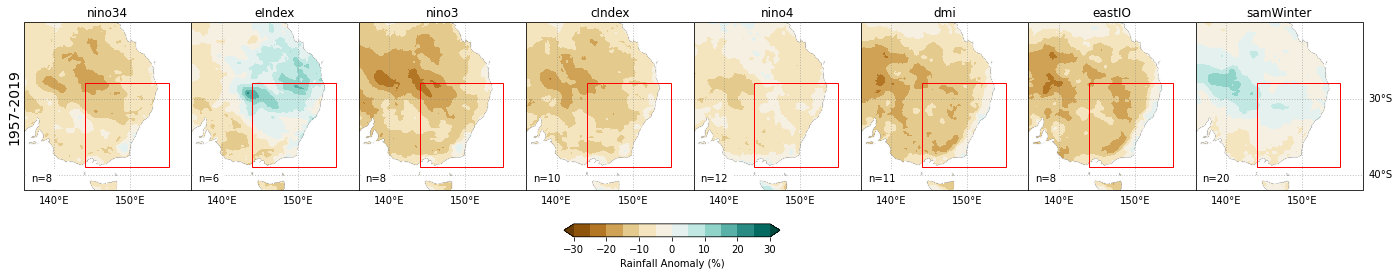

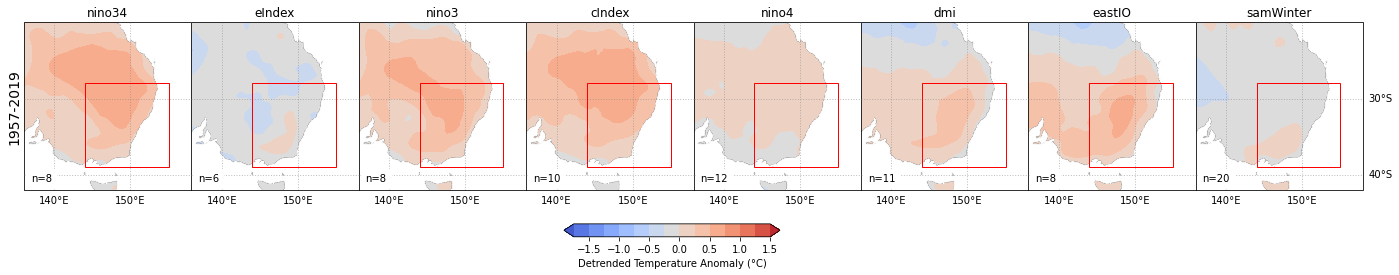

summer


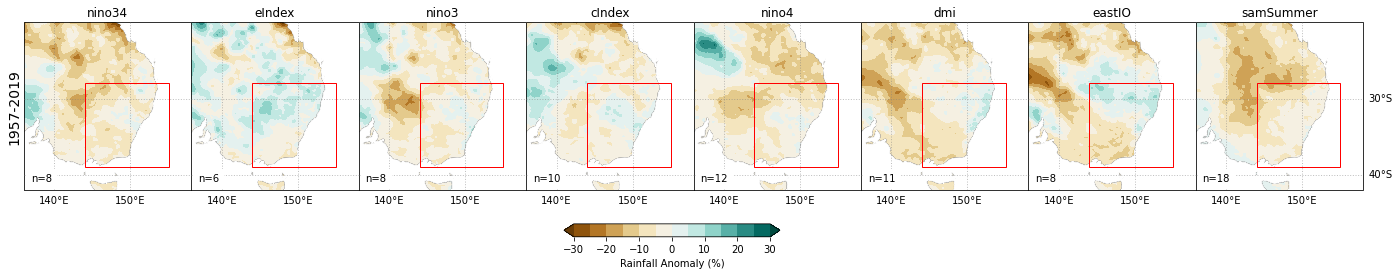

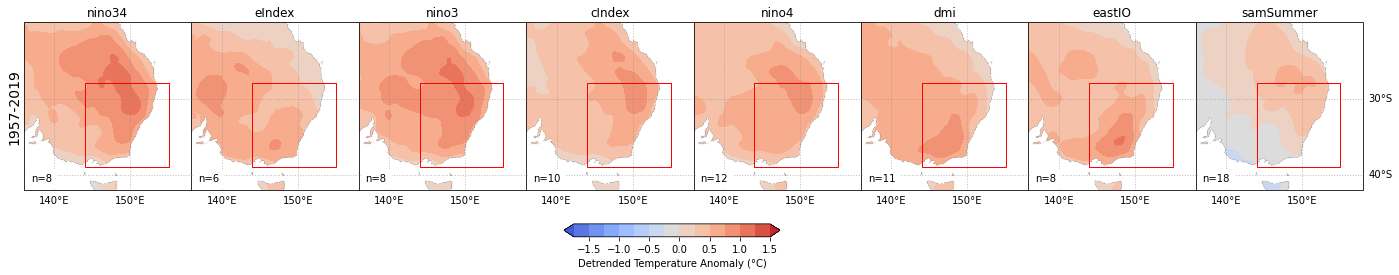

Fire:neg
winter


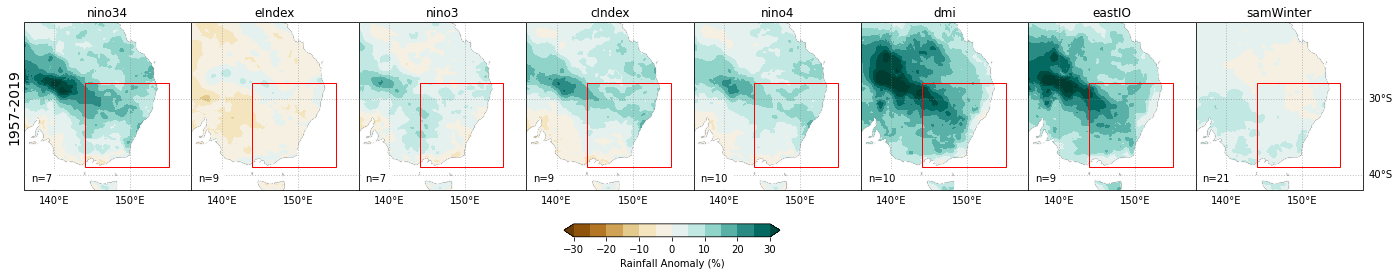

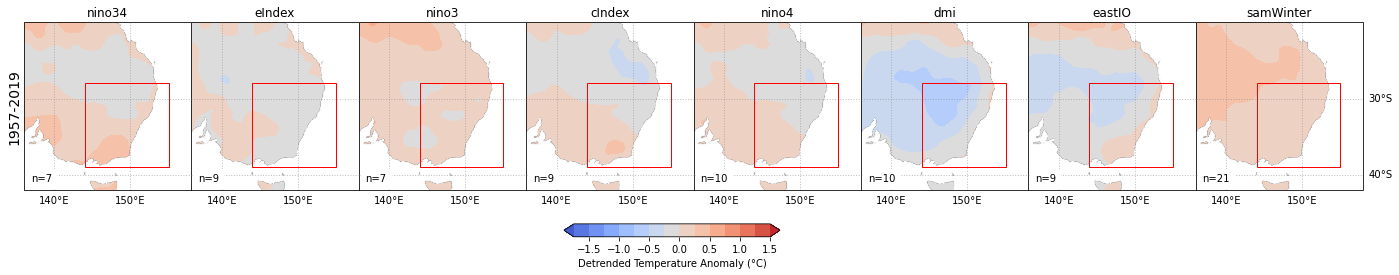

summer


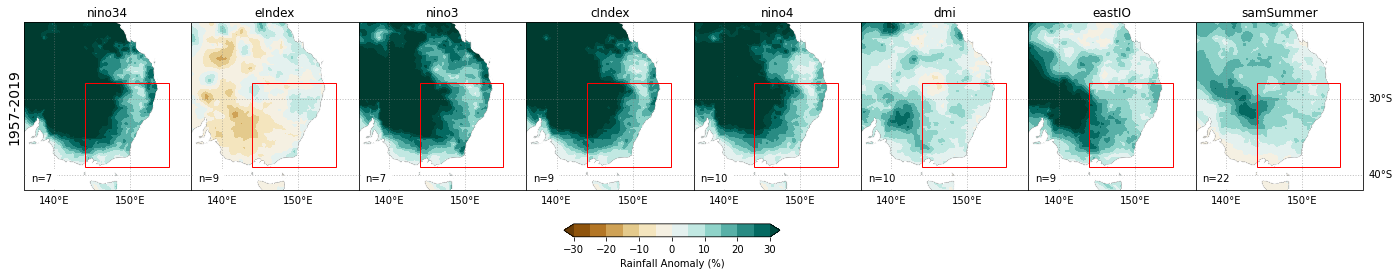

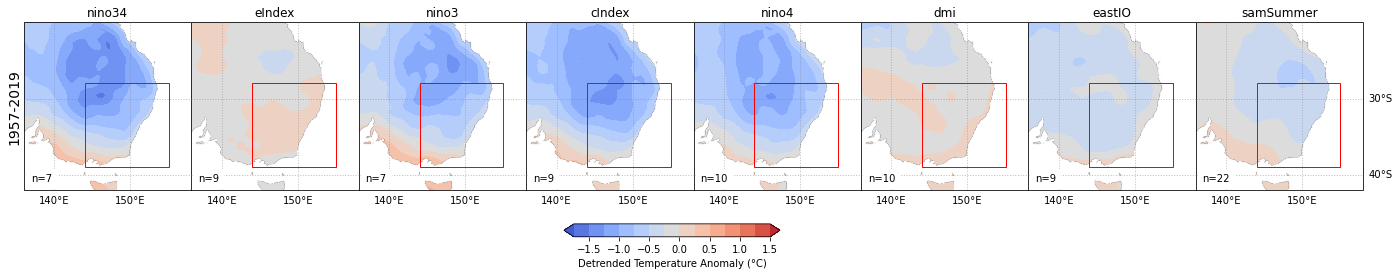

In [10]:
%run helpers/impactPlots.ipynb
for iFire in ['pos','neg']:
    print('Fire:'+iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)
        axs=indexPlotter(
            prXr[iSeason.capitalize()+' Rain'], #sourceData
            eventsXr.sel(fire=iFire, drop=True), 
            eventsLs[iSeason], #names of event types
            stipling=False,
            showOcean=False,
            cbarLabel='Rainfall Anomaly (%)'
        )
        axs[0].text(
            -0.1, 0.5,  #xy relative to bottom left of axis
            '1957-2019', #yearRange
            rotation='vertical', 
            transform=axs[0].transAxes, 
            verticalalignment='center',
            fontsize=14
        )
                
        plt.show()
        
        axs=indexPlotter(
            detrendTsXr[iSeason.capitalize()+' Temp'],
            eventsXr.sel(fire=iFire, drop=True), 
            eventsLs[iSeason],
            stipling=False,
            showOcean=False,
            cbarLabel='Detrended Temperature Anomaly (°C)'
        )
        axs[0].text(
            -0.1, 0.5,  #xy relative to bottom left of axis
            '1957-2019', #yearRange
            rotation='vertical', 
            transform=axs[0].transAxes, 
            verticalalignment='center',
            fontsize=14
        )
        plt.show()

# The CMIP6 data to compare to

In [11]:
cmipCompounds=xarray.open_dataset('results/cmip6Compounds.nc').sel(experiment='ssp585',year=slice(1957,2019),drop=True)

In [12]:
cmipPrXr=xarray.open_dataset('results/cmip6PrXr.nc').sel(year=slice(1957,2019))
cmipDetrendTsXr=xarray.open_dataset('results/cmip6DetrendTsXr.nc').sel(year=slice(1957,2019))


# Compound them and see what happens

In [13]:
allCompounds=compound.compound(eventsXr)

nino34DmiSamwinter
nino34DmiSamsummer
nino34EastioSamwinter
nino34EastioSamsummer
cIndexDmiSamwinter
cIndexDmiSamsummer
cIndexEastioSamwinter
cIndexEastioSamsummer
nino4DmiSamwinter
nino4DmiSamsummer
nino4EastioSamwinter
nino4EastioSamsummer
ecCombinedDmiSamwinter
ecCombinedDmiSamsummer
ecCombinedEastioSamwinter
ecCombinedEastioSamsummer
eIndexDmiSamwinter
eIndexDmiSamsummer
eIndexEastioSamwinter
eIndexEastioSamsummer
nino3DmiSamwinter
nino3DmiSamsummer
nino3EastioSamwinter
nino3EastioSamsummer


In [14]:
indexSet='ecCombinedDmiSam'

In [15]:
eventsList=['enso+iod', 'enso+sam', 'iod+sam', 'all3']

winter


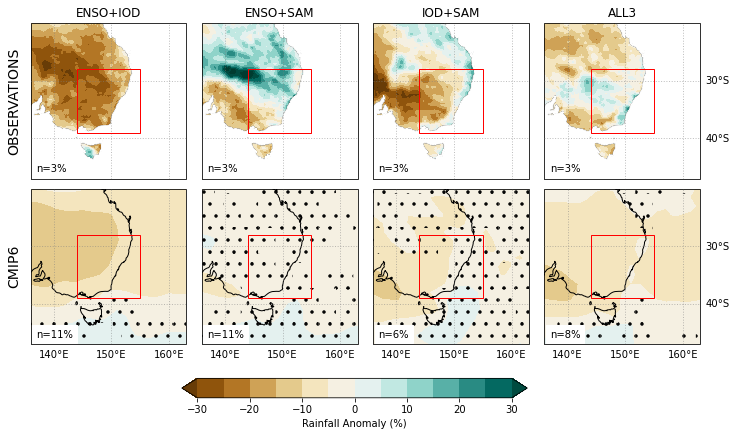

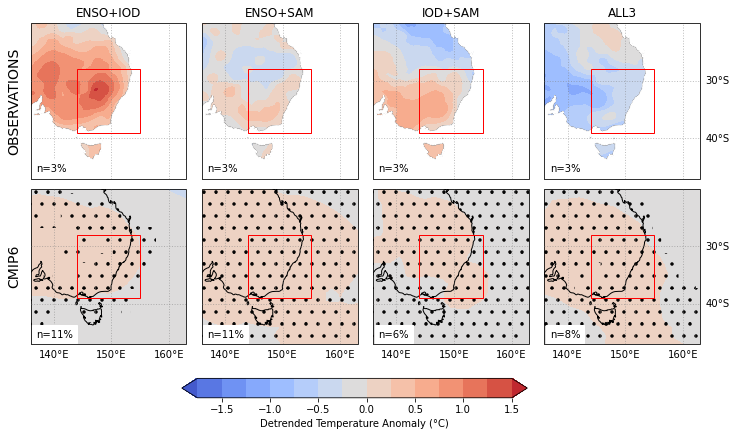

summer


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


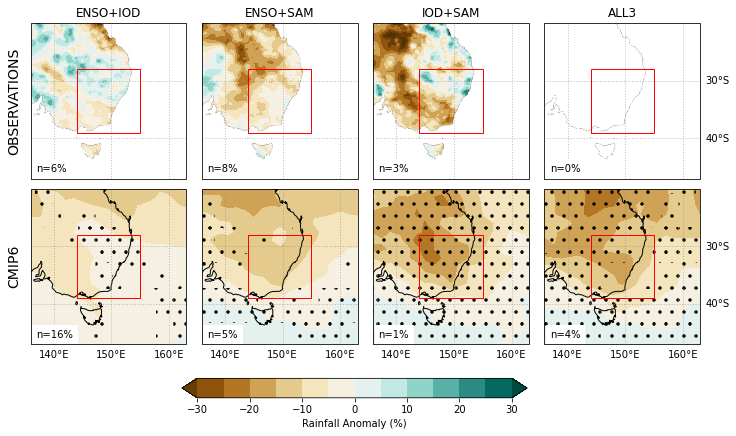

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


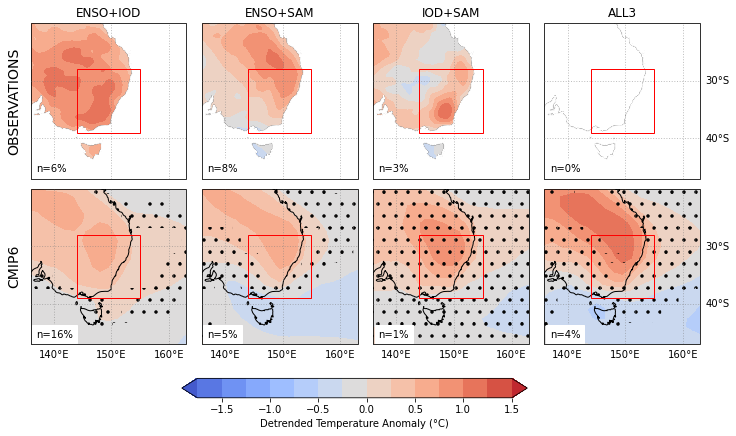

In [16]:
%run helpers/impactPlots.ipynb

import matplotlib.cm as cm
import matplotlib.colorbar as cb
for iSeason in ['winter','summer']:
    print(iSeason)
    for iImpact in ['Rain',
                    'Temp']:
    
        nRows=2
        nCols=4

        fig=plt.figure(figsize=(nCols*3,nRows*4+1))

        #First row is observations
        with allCompounds[indexSet+iSeason].sel(fire='pos',drop=True) as firstRow:

            #First cell is ENSO+IOD
            ax=plt.subplot(nRows+1,nCols,1,projection=ccrs.PlateCarree())
            cs,gl= singleAnom(firstRow,'enso+iod',iSeason,iImpact)
            ax.set_title('ENSO+IOD')
            gl.bottom_labels=False
            gl.right_labels=False

            #in the first column, put a y-label
            ax.text(
                -0.15, 0.5,  #xy relative to bottom left of axis
                str('OBSERVATIONS'), #yearRange
                rotation='vertical', transform=ax.transAxes, verticalalignment='center',fontsize=14
            )

            #2nd cell is ENSO only
            ax=plt.subplot(nRows+1,nCols,2,projection=ccrs.PlateCarree())
            cs,gl= singleAnom(firstRow,'enso+sam',iSeason,iImpact)
            ax.set_title('ENSO+SAM')
            gl.bottom_labels=False
            gl.right_labels=False

            #3rd cell is IOD only
            ax=plt.subplot(nRows+1,nCols,3,projection=ccrs.PlateCarree())
            cs,gl= singleAnom(firstRow,'iod+sam',iSeason,iImpact)
            ax.set_title('IOD+SAM')
            gl.bottom_labels=False
            gl.right_labels=False


             #4th cell is ALL3
            ax=plt.subplot(nRows+1,nCols,4,projection=ccrs.PlateCarree())
            cs,gl= singleAnom(firstRow,'all3',iSeason,iImpact)
            ax.set_title('ALL3')
            gl.bottom_labels=False

        #Second row is years 2050 to 2099
        if iImpact=='Rain':
            impactXr=cmipPrXr
        elif iImpact=='Temp':
            impactXr=cmipDetrendTsXr
        
        with cmipCompounds[indexSet+iSeason].sel(fire='pos',drop=True) as secondRow:

            #First cell is All3
            ax=plt.subplot(nRows+1,nCols,nCols+1,projection=ccrs.PlateCarree())
            cs,gl= singleAnomWithStipling(secondRow,'enso+iod',iSeason,iImpact,impactXr)
            gl.right_labels=False
            #in the first column, put a y-label
            ax.text(
                -0.15, 0.5,  #xy relative to bottom left of axis
                str('CMIP6'), #yearRange
                rotation='vertical', transform=ax.transAxes, verticalalignment='center',fontsize=14
            )

            #2nd cell is ENSO + SAM only
            ax=plt.subplot(nRows+1,nCols,nCols+2,projection=ccrs.PlateCarree())
            cs,gl= singleAnomWithStipling(secondRow,'enso+sam',iSeason,iImpact,impactXr)
            gl.right_labels=False

            #3rd cell is IOD only
            ax=plt.subplot(nRows+1,nCols,nCols+3,projection=ccrs.PlateCarree())
            cs,gl = singleAnomWithStipling(secondRow,'iod+sam',iSeason,iImpact,impactXr)
            gl.right_labels=False

            ax=plt.subplot(nRows+1,nCols,nCols+4,projection=ccrs.PlateCarree())
            cs,gl = singleAnomWithStipling(secondRow,'all3',iSeason,iImpact,impactXr)

        # add some space between rows
        plt.subplots_adjust(hspace=0.05, wspace=0.1)

        if iImpact=='Rain':
            label = 'Rainfall Anomaly (%)'
        elif iImpact=='Temp':
            label = 'Detrended Temperature Anomaly (°C)'

        #put a color bar on
        ax=fig.add_axes([0.3,0.3,0.4,0.03])
        cbar=plt.colorbar(
            cm.ScalarMappable(cs.norm,cs.cmap),
            orientation='horizontal', 
            cax=ax, 
            extend='both', 
            boundaries=cs.get_array(), 
            label=label
        )

        plt.savefig('figures/obsAndModel/cmipDry'+iImpact+iSeason+'.pdf',bbox_inches='tight')
        
        plt.show()


winter


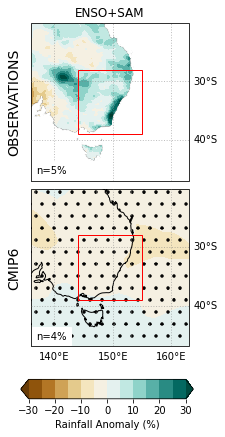

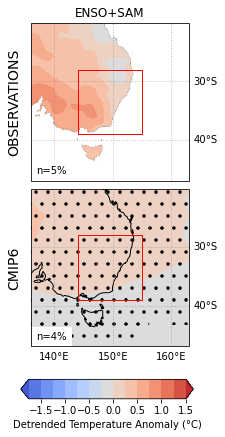

summer


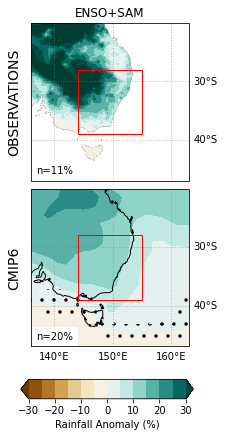

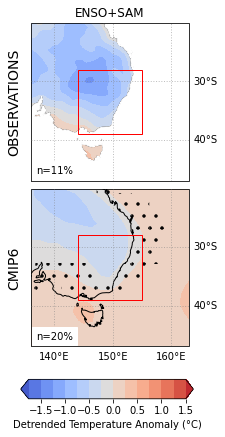

In [17]:
%run helpers/impactPlots.ipynb

import matplotlib.cm as cm
import matplotlib.colorbar as cb
for iSeason in ['winter','summer']:
    print(iSeason)
    for iImpact in ['Rain',
                    'Temp']:
    
        nRows=2
        nCols=1

        fig=plt.figure(figsize=(nCols*3,nRows*4+1))

        #First row is observations
        with allCompounds[indexSet+iSeason].sel(fire='neg',drop=True) as firstRow:

            #First cell is ENSO+IOD
            ax=plt.subplot(nRows+1,nCols,1,projection=ccrs.PlateCarree())
            cs,gl= singleAnom(firstRow,'enso+sam',iSeason,iImpact)
            ax.set_title('ENSO+SAM')
            gl.bottom_labels=False

            #in the first column, put a y-label
            ax.text(
                -0.15, 0.5,  #xy relative to bottom left of axis
                str('OBSERVATIONS'), #yearRange
                rotation='vertical', transform=ax.transAxes, verticalalignment='center',fontsize=14
            )

        #Second row is years 2050 to 2099
        if iImpact=='Rain':
            impactXr=cmipPrXr
        elif iImpact=='Temp':
            impactXr=cmipDetrendTsXr
        
        with cmipCompounds[indexSet+iSeason].sel(fire='neg',drop=True) as secondRow:

            #First cell is All3
            ax=plt.subplot(nRows+1,nCols,nCols+1,projection=ccrs.PlateCarree())
            cs,gl= singleAnomWithStipling(secondRow,'enso+sam',iSeason,iImpact,impactXr)
            #in the first column, put a y-label
            ax.text(
                -0.15, 0.5,  #xy relative to bottom left of axis
                str('CMIP6'), #yearRange
                rotation='vertical', transform=ax.transAxes, verticalalignment='center',fontsize=14
            )

            
        # add some space between rows
        plt.subplots_adjust(hspace=0.05, wspace=0.1)

        if iImpact=='Rain':
            label = 'Rainfall Anomaly (%)'
        elif iImpact=='Temp':
            label = 'Detrended Temperature Anomaly (°C)'

        #put a color bar on
        ax=fig.add_axes([0.1,0.3,0.8,0.03])
        cbar=plt.colorbar(
            cm.ScalarMappable(cs.norm,cs.cmap),
            orientation='horizontal', 
            cax=ax, 
            extend='both', 
            boundaries=cs.get_array(), 
            label=label
        )

        plt.savefig('figures/obsAndModel/cmipWet'+iImpact+iSeason+'.pdf',bbox_inches='tight')
        
        plt.show()


# And comparison between the enso indices

In [18]:
ensoIodEventsXr=allCompounds.sel(compound=['enso+iod','enso+sam','all3'], drop=True).any('compound')

In [19]:
ensoIodEventsLs=list(ensoIodEventsXr.data_vars)

In [20]:
ensoIodEventsLs

['nino34DmiSamwinter',
 'nino34DmiSamsummer',
 'nino34EastioSamwinter',
 'nino34EastioSamsummer',
 'cIndexDmiSamwinter',
 'cIndexDmiSamsummer',
 'cIndexEastioSamwinter',
 'cIndexEastioSamsummer',
 'nino4DmiSamwinter',
 'nino4DmiSamsummer',
 'nino4EastioSamwinter',
 'nino4EastioSamsummer',
 'ecCombinedDmiSamwinter',
 'ecCombinedDmiSamsummer',
 'ecCombinedEastioSamwinter',
 'ecCombinedEastioSamsummer',
 'eIndexDmiSamwinter',
 'eIndexDmiSamsummer',
 'eIndexEastioSamwinter',
 'eIndexEastioSamsummer',
 'nino3DmiSamwinter',
 'nino3DmiSamsummer',
 'nino3EastioSamwinter',
 'nino3EastioSamsummer']

In [21]:
ensoIodEventLs=[
    #'ecCombinedDmiSam',
    'eIndexDmiSam','cIndexDmiSam',
    #'nino34DmiSam'
]


pos
winter


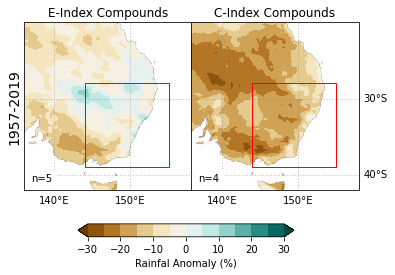

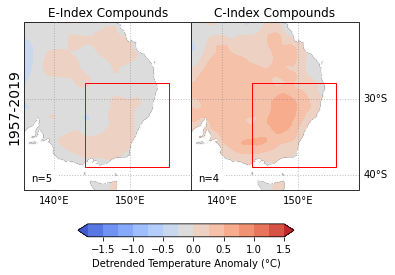

summer


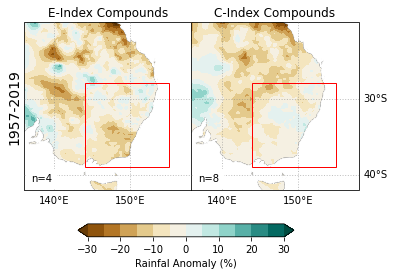

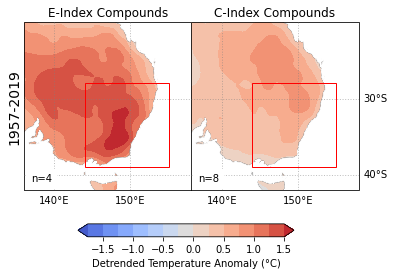

neg
winter


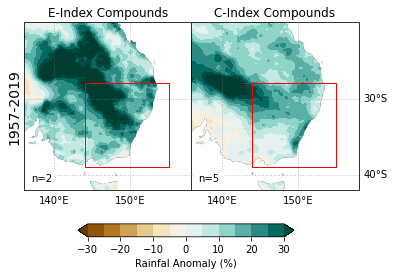

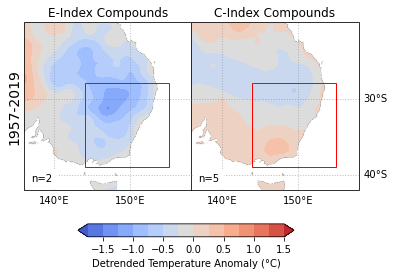

summer


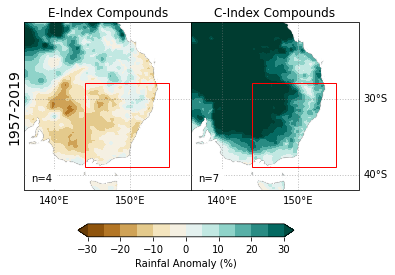

In [ ]:
%run helpers/impactPlots.ipynb
for iFire in ['pos','neg']:
    print(iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)

        axs=indexPlotter(
            prXr[iSeason.capitalize()+' Rain'],
            ensoIodEventsXr[[start+iSeason for start in ensoIodEventLs]].sel(fire=iFire, drop=True), 
            [start+iSeason for start in ensoIodEventLs], 
            stipling=False, 
            showOcean=False,
            cbarLabel='Rainfal Anomaly (%)'
        )
        axs[0].set_title('E-Index Compounds')
        axs[1].set_title('C-Index Compounds')
        axs[0].text(-0.1, 0.5,  #xy relative to bottom left of axis
                        '1957-2019', #yearRange
                        rotation='vertical', transform=axs[0].transAxes, 
                        verticalalignment='center',fontsize=14)

        plt.savefig('figures/ECImpacts/obs'+iFire+iSeason.capitalize()+'Rain.pdf',
            bbox_inches='tight'
        )
        plt.show()
        
        axs=indexPlotter(
            detrendTsXr[iSeason.capitalize() + ' Temp'], 
            ensoIodEventsXr[[start+iSeason for start in ensoIodEventLs]].sel(fire=iFire, drop=True), 
            [start+iSeason for start in ensoIodEventLs], 
            stipling=False, 
            showOcean=False,
            cbarLabel='Detrended Temperature Anomaly (°C)'
        )
        
        axs[0].set_title('E-Index Compounds')
        axs[1].set_title('C-Index Compounds')
        axs[0].text(-0.1, 0.5,  #xy relative to bottom left of axis
                        '1957-2019', #yearRange
                        rotation='vertical', transform=axs[0].transAxes, 
                        verticalalignment='center',fontsize=14)

        plt.savefig(
            'figures/ECImpacts/obs'+iFire+iSeason.capitalize()+'Temp.pdf',
            bbox_inches='tight'
        )
        plt.show()